In [1]:
# Import necessary libraries
import re

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

## 1. Data Loading

In [2]:
# Read men's and women's world records from CSV files
men_records = pd.read_csv("data/men_world_records.csv", sep=",")
women_records = pd.read_csv("data/women_world_records.csv", sep=",")

## 2. Data Preparation

In [3]:
# Filter women's records to include only those disciplines that also exist in men's records
women_records = women_records[women_records['DISCIPLINE'].isin(men_records['DISCIPLINE'].unique())]

# Select and rename performance columns for men and women
men_perf = men_records[['DISCIPLINE', 'PERF']].rename(columns={'PERF': 'PERF_MEN'})
women_perf = women_records[['DISCIPLINE', 'PERF']].rename(columns={'PERF': 'PERF_WOMEN'})

# Merge men's and women's performance data on discipline
df = pd.merge(men_perf, women_perf, on='DISCIPLINE', how='inner')

# Keep only the last record for each discipline
df = df.groupby('DISCIPLINE').last().reset_index()

## 3. Time Conversion and Performance Gap Calculation

In [4]:
not_time = ['Decathlon', 'Discus Throw', 'Hammer Throw', 'High Jump', 'Javelin Throw', 'Long Jump', 'One Hour', 'Pole Vault', 'Shot Put', 'Triple Jump']
df['IS_TIME'] = df['DISCIPLINE'].apply(lambda x: 1 if x not in not_time else 0)

# Function to convert different formats of time to centiseconds for comparison
def convert_to_centiseconds(time_str):

    # Remove all characters except numbers, colons and periods
    time_str = re.sub(r'[^0-9:.]', '', time_str)

    if '.' in time_str:
        try:
            time_obj = datetime.strptime(time_str, '%H:%M:%S.%f')
        except ValueError:
            try:
                time_obj = datetime.strptime(time_str, '%M:%S.%f')
            except ValueError:
                time_obj = datetime.strptime(time_str, '%S.%f')
        total_centiseconds = (time_obj.hour * 3600 + time_obj.minute * 60 + time_obj.second) * 100 + int(time_obj.microsecond / 10000)
    else:
        try:
            time_obj = datetime.strptime(time_str, '%H:%M:%S')
        except ValueError:
            try:
                time_obj = datetime.strptime(time_str, '%M:%S')
            except ValueError:
                time_obj = datetime.strptime(time_str, '%S')
        total_centiseconds = (time_obj.hour * 3600 + time_obj.minute * 60 + time_obj.second) * 100
    return total_centiseconds

perf_gap_percent_list = []

for row in df.itertuples():
    if row.IS_TIME == 1:
        men_time = convert_to_centiseconds(row.PERF_MEN)
        women_time = convert_to_centiseconds(row.PERF_WOMEN)

        perf_gap_percent = (abs(men_time - women_time) / men_time) * 100
    else:
        perf_gap_percent = (abs(float(row.PERF_MEN) - float(row.PERF_WOMEN)) / float(row.PERF_MEN)) * 100
    
    perf_gap_percent_list.append(perf_gap_percent)

df['PERF_GAP_PERCENT'] = perf_gap_percent_list

## 4. Categorization of Disciplines

In [5]:
# Define discipline categories
Sprints = ["100 Metres", "200 Metres", "400 Metres"]
Middle_Long = ["800 Metres", "1500 Metres", "5000 Metres", "10000 Metres", "3000 Metres Steeplechase"]
Hurdles = ["400 Metres Hurdles"]
Road = ["Half Marathon", "Marathon"]
Jumps = ["High Jump", "Pole Vault", "Long Jump", "Triple Jump"]
Throws = ["Shot Put", "Discus Throw", "Hammer Throw", "Javelin Throw"]
Combined = ["Decathlon", "Heptathlon"]
Walks = ["20 Kilometres Walk", "50 Kilometres Walk"]
Relays = ["4x100 Metres Relay", "4x400 Metres Relay"]

# Categorize each discipline
for i, row in df.iterrows():
    if row['DISCIPLINE'] in Sprints:
        df.at[i, 'CATEGORY'] = 'Sprints'
    elif row['DISCIPLINE'] in Middle_Long:
        df.at[i, 'CATEGORY'] = 'Middle-Long Distance'
    elif row['DISCIPLINE'] in Hurdles:
        df.at[i, 'CATEGORY'] = 'Hurdles'
    elif row['DISCIPLINE'] in Road:
        df.at[i, 'CATEGORY'] = 'Road'
    elif row['DISCIPLINE'] in Jumps:
        df.at[i, 'CATEGORY'] = 'Jumps'
    elif row['DISCIPLINE'] in Throws:
        df.at[i, 'CATEGORY'] = 'Throws'
    elif row['DISCIPLINE'] in Combined:
        df.at[i, 'CATEGORY'] = 'Combined Events'
    elif row['DISCIPLINE'] in Walks:
        df.at[i, 'CATEGORY'] = 'Walks'
    elif row['DISCIPLINE'] in Relays:
        df.at[i, 'CATEGORY'] = 'Relays'
    else:
        df.at[i, 'CATEGORY'] = 'Other'

---
# Records gap between men and women

/var/folders/bm/bfchd71s5dj_my2slhz34b340000gn/T/ipykernel_63781/3250572011.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['DISCIPLINE'] = pd.Categorical(filtered_df['DISCIPLINE'], categories=order, ordered=True)


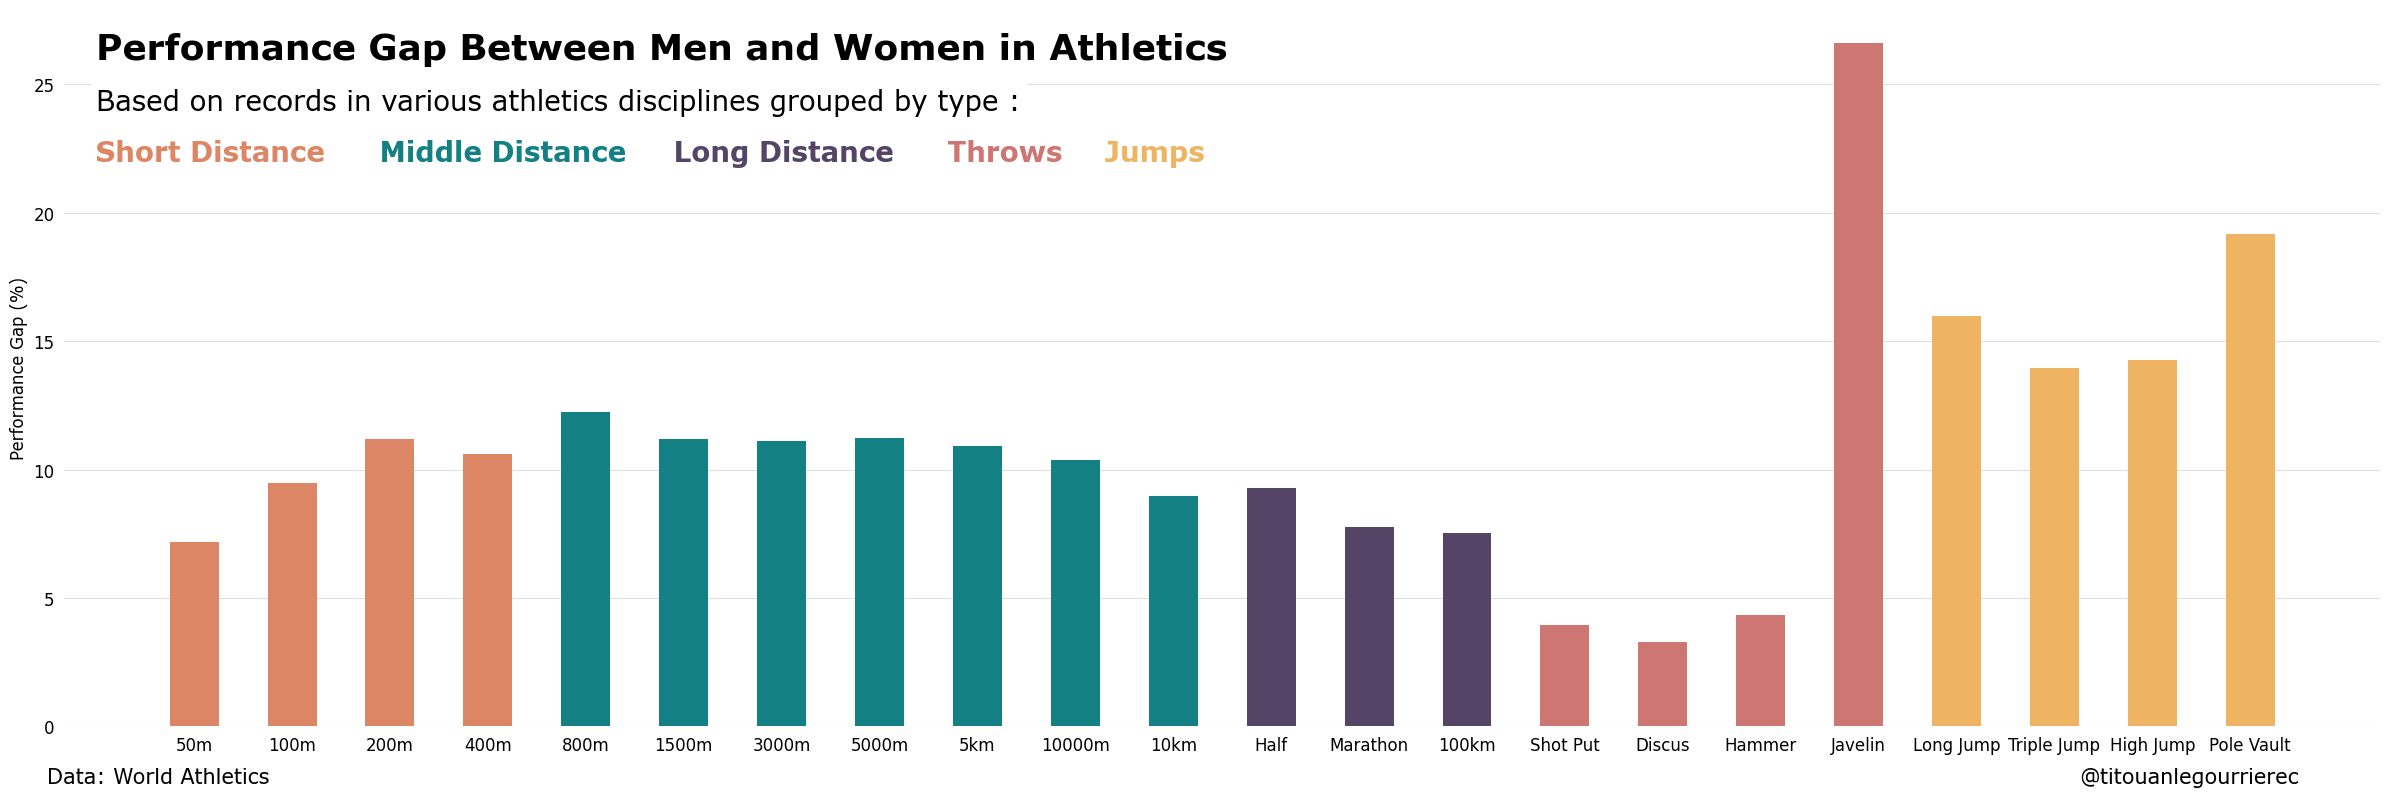

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Filter disciplines
filtered_df = df[df['DISCIPLINE'].isin(['50 Metres', '100 Metres', '200 Metres', '400 Metres', '800 Metres', '1500 Metres', '3000 Metres', '5000 Metres', '10,000 Metres', '5 Kilometres Road', '10 Kilometres Road', 'Half Marathon', 'Marathon', '100 Kilometres Road', 'Shot Put', 'Discus Throw', 'Hammer Throw', 'Javelin Throw', 'Long Jump', 'Triple Jump', 'High Jump', 'Pole Vault'])] #  'Long Jump', 'Triple Jump', 'High Jump', 'Pole Vault'

# Reorganize disciplines in desired order
order = ['50 Metres', '100 Metres', '200 Metres', '400 Metres', '800 Metres', '1500 Metres', '3000 Metres', '5000 Metres', '5 Kilometres Road', '10,000 Metres', '10 Kilometres Road', 'Half Marathon', 'Marathon', '100 Kilometres Road', 'Shot Put', 'Discus Throw', 'Hammer Throw', 'Javelin Throw', 'Long Jump', 'Triple Jump', 'High Jump', 'Pole Vault']
filtered_df['DISCIPLINE'] = pd.Categorical(filtered_df['DISCIPLINE'], categories=order, ordered=True)
filtered_df = filtered_df.sort_values('DISCIPLINE')

# Mapping of discipline names to shorter titles
short_titles = {
    '50 Metres': '50m',
    '100 Metres': '100m',
    '200 Metres': '200m',
    '400 Metres': '400m',
    '800 Metres': '800m',
    '1500 Metres': '1500m',
    '3000 Metres': '3000m',
    '5000 Metres': '5000m',
    '10,000 Metres': '10000m',
    '5 Kilometres Road': '5km',
    '10 Kilometres Road': '10km',
    'Half Marathon': 'Half',
    'Marathon': 'Marathon',
    '100 Kilometres Road': '100km',
    'Shot Put': 'Shot Put',
    'Discus Throw': 'Discus',
    'Hammer Throw': 'Hammer',
    'Javelin Throw': 'Javelin',
    'Long Jump' : 'Long Jump',
    'Triple Jump' : 'Triple Jump',
    'High Jump': 'High Jump',
    'Pole Vault': 'Pole Vault'
}
filtered_df['SHORT_DISCIPLINE'] = filtered_df['DISCIPLINE'].map(short_titles)

# Define colors for each group
colors = ['#DC8665'] * 4 + ['#138084'] * 7 + ['#544567'] * 3 + ['#CE7672'] * 4 + ['#EEB462'] * 4

# Plotting
plt.figure(figsize=(24, 8))
plt.bar(filtered_df['SHORT_DISCIPLINE'], filtered_df['PERF_GAP_PERCENT'], color=colors, width=0.5, zorder=2)

plt.text(-1, 26, 'Performance Gap Between Men and Women in Athletics', font='Verdana', fontsize=26, fontweight='bold', ha='left', bbox=dict(facecolor='white', edgecolor='none'))
plt.text(-1, 24, 'Based on records in various athletics disciplines grouped by type :', font='Verdana', fontsize=20, ha='left', bbox=dict(facecolor='white', edgecolor='none'))

plt.text(-1.1, 22, ' Short Distance', font='Verdana', fontsize=20, ha='left', color='#DC8665', fontweight='bold', bbox=dict(facecolor='white', edgecolor='none'))
plt.text(1.8, 22, ' Middle Distance', font='Verdana', fontsize=20, ha='left', color='#138084', fontweight='bold', bbox=dict(facecolor='white', edgecolor='none'))
plt.text(4.8, 22, ' Long Distance', font='Verdana', fontsize=20, ha='left', color='#544567', fontweight='bold', bbox=dict(facecolor='white', edgecolor='none'))
plt.text(7.6, 22, ' Throws', font='Verdana', fontsize=20, ha='left', color='#CE7672', fontweight='bold', bbox=dict(facecolor='white', edgecolor='none'))
plt.text(9.2, 22, ' Jumps', font='Verdana', fontsize=20, ha='left', color='#EEB462', fontweight='bold', bbox=dict(facecolor='white', edgecolor='none'))

plt.text(-1.5, -2.2, 'Data: World Athletics', font='Verdana', fontsize=15, ha='left', color='black', bbox=dict(facecolor='white', edgecolor='none'))
plt.text(21.5, -2.2, '@titouanlegourrierec', font='Verdana', fontsize=15, ha='right', color='black', bbox=dict(facecolor='white', edgecolor='none'))

plt.grid(True, axis='y', linestyle='-', alpha=0.4, zorder=1)

plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Performance Gap (%)', font='Verdana', fontsize=12)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().yaxis.set_ticks_position('none')
plt.gca().xaxis.set_ticks_position('none')
plt.tight_layout()

plt.show()

/var/folders/bm/bfchd71s5dj_my2slhz34b340000gn/T/ipykernel_63781/3259101217.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['DISCIPLINE'] = pd.Categorical(filtered_df['DISCIPLINE'], categories=order, ordered=True)


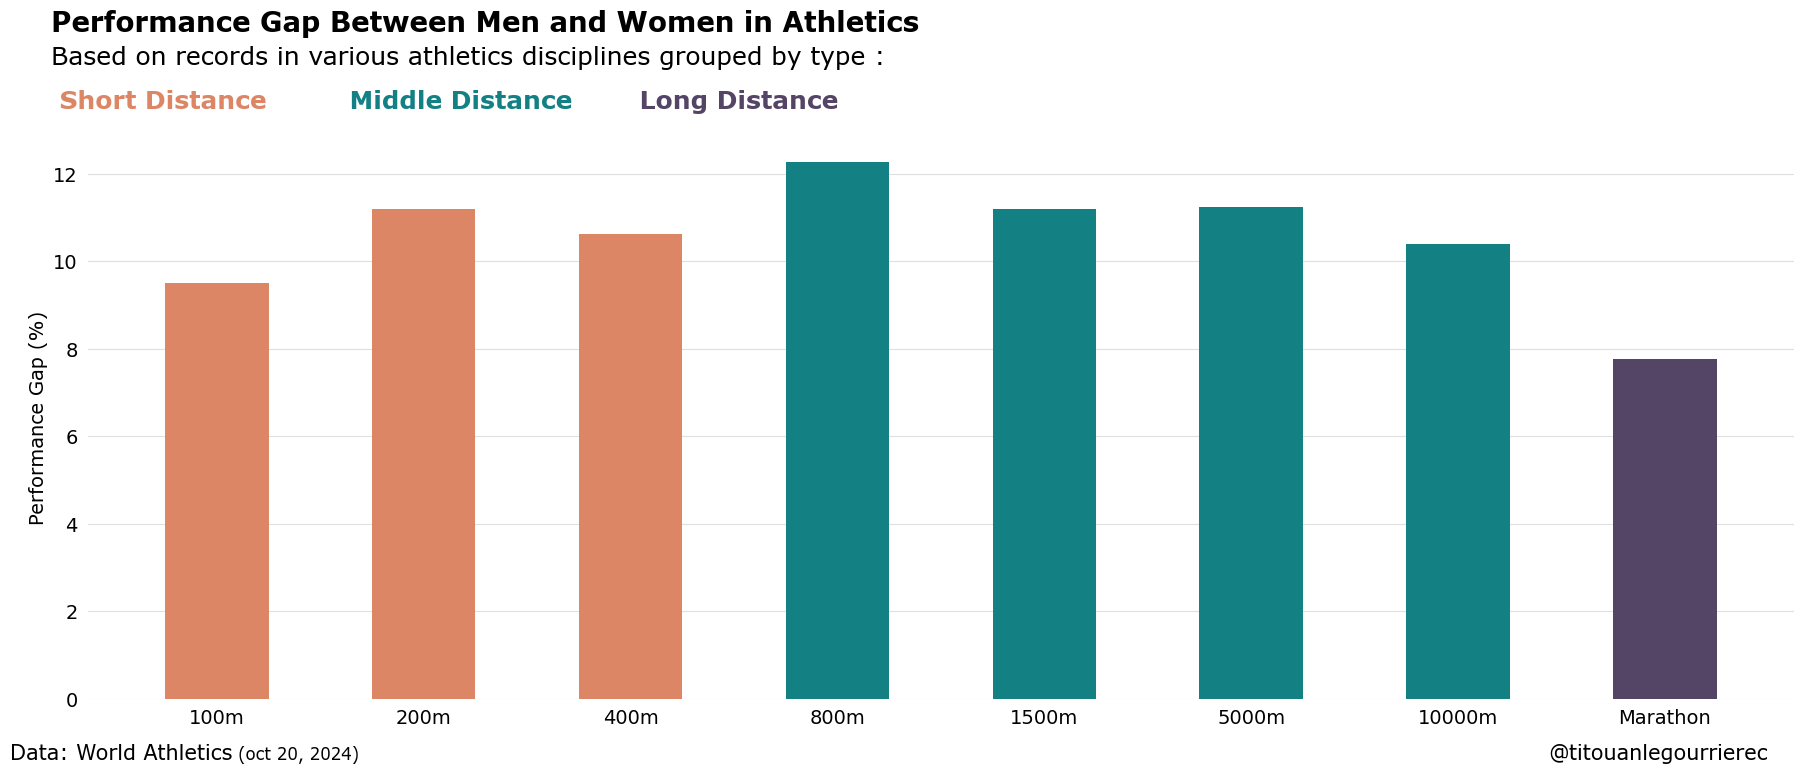

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Filter disciplines
filtered_df = df[df['DISCIPLINE'].isin(['100 Metres', '200 Metres', '400 Metres', '800 Metres', '1500 Metres', '5000 Metres', '10,000 Metres', 'Marathon'])]

# Reorganize disciplines in desired order
order = ['100 Metres', '200 Metres', '400 Metres', '800 Metres', '1500 Metres', '5000 Metres', '10,000 Metres', 'Marathon', '100 Kilometres Road']
filtered_df['DISCIPLINE'] = pd.Categorical(filtered_df['DISCIPLINE'], categories=order, ordered=True)
filtered_df = filtered_df.sort_values('DISCIPLINE')

# Mapping of discipline names to shorter titles
short_titles = {
    '100 Metres': '100m',
    '200 Metres': '200m',
    '400 Metres': '400m',
    '800 Metres': '800m',
    '1500 Metres': '1500m',
    '5000 Metres': '5000m',
    '10,000 Metres': '10000m',
    'Marathon': 'Marathon',
}
filtered_df['SHORT_DISCIPLINE'] = filtered_df['DISCIPLINE'].map(short_titles)



# Define colors for each group
colors = ['#DC8665'] * 3 + ['#138084'] * 4 + ['#544567'] * 1

# Plotting
plt.figure(figsize=(18, 8))
plt.bar(filtered_df['SHORT_DISCIPLINE'], filtered_df['PERF_GAP_PERCENT'], color=colors, width=0.5, zorder=2)

plt.text(-0.8, 15.25, 'Performance Gap Between Men and Women in Athletics', font='Verdana', fontsize=20, fontweight='bold', ha='left', bbox=dict(facecolor='white', edgecolor='none'))
plt.text(-0.8, 14.5, 'Based on records in various athletics disciplines grouped by type :', font='Verdana', fontsize=18, ha='left', bbox=dict(facecolor='white', edgecolor='none'))

plt.text(-0.8, 13.5, ' Short Distance', font='Verdana', fontsize=18, ha='left', color='#DC8665', fontweight='bold', bbox=dict(facecolor='white', edgecolor='none'))
plt.text(0.6, 13.5, ' Middle Distance', font='Verdana', fontsize=18, ha='left', color='#138084', fontweight='bold', bbox=dict(facecolor='white', edgecolor='none'))
plt.text(2, 13.5, ' Long Distance', font='Verdana', fontsize=18, ha='left', color='#544567', fontweight='bold', bbox=dict(facecolor='white', edgecolor='none'))

plt.text(-1, -1.4, 'Data: World Athletics', font='Verdana', fontsize=15, ha='left', color='black', bbox=dict(facecolor='white', edgecolor='none'))
plt.text(0.1, -1.4, '(oct 20, 2024)', font='Verdana', fontsize=12, ha='left', color='black', bbox=dict(facecolor='white', edgecolor='none'))
plt.text(7.5, -1.4, '@titouanlegourrierec', font='Verdana', fontsize=15, ha='right', color='black', bbox=dict(facecolor='white', edgecolor='none'))

plt.grid(True, axis='y', linestyle='-', alpha=0.4, zorder=1)

plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Performance Gap (%)', font='Verdana', fontsize=14)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().yaxis.set_ticks_position('none')
plt.gca().xaxis.set_ticks_position('none')
plt.tight_layout()

plt.show()

---
# Top 20 performances sex gap

In [8]:
def topsexgap(df: pd.DataFrame,
              discipline: str,
              year: int,
              top_n: int = 20) -> float:
    """
    Calculate the average percentage gap between the performance of men and women in a given discipline and year for the top_n performances.

    Parameters:
        - df (pd.DataFrame): The DataFrame containing the performance data.
        - discipline (str): The discipline for which to calculate the sex gap (e.g., "100-metres", "marathon").
        - year (int): The year for which to calculate the sex gap.
        - top_n (int, optional): The number of top performances to consider. Default is 20.

    Returns:
        - top_sex_gap (float): The average percentage gap between the performance of men and women.
        - sex_gap_list (list): A list of percentage gaps for each rank from 1 to top_n.

    Example:
    --------
    >>> df = pd.read_csv('performance_data.csv')
    >>> avg_gap, gap_list = topsexgap(df, discipline="100-metres", year=2023, top_n=10)
    >>> print(f"Average percentage gap: {avg_gap}")
    >>> print(f"Percentage gaps: {gap_list}")
    """

    df_men = df[(df["YEAR"] == year) & (df["SEX"] == "men") & (df["DISCIPLINE"] == discipline)].copy()
    df_women = df[(df["YEAR"] == year) & (df["SEX"] == "women") & (df["DISCIPLINE"] == discipline)].copy()

    df_men["PERF"] = df_men['MARK'].apply(convert_to_centiseconds)
    df_women["PERF"] = df_women['MARK'].apply(convert_to_centiseconds)

    top_sex_gap = 0
    sex_gap_list = []
    for i in range(top_n):
        PERF_MEN = df_men.iloc[i]["PERF"]
        PERF_WOMEN = df_women.iloc[i]["PERF"]

        sex_gap = ((abs(PERF_MEN - PERF_WOMEN)/PERF_MEN)*100)

        sex_gap_list.append(sex_gap)
        top_sex_gap += sex_gap/top_n

    return top_sex_gap, sex_gap_list

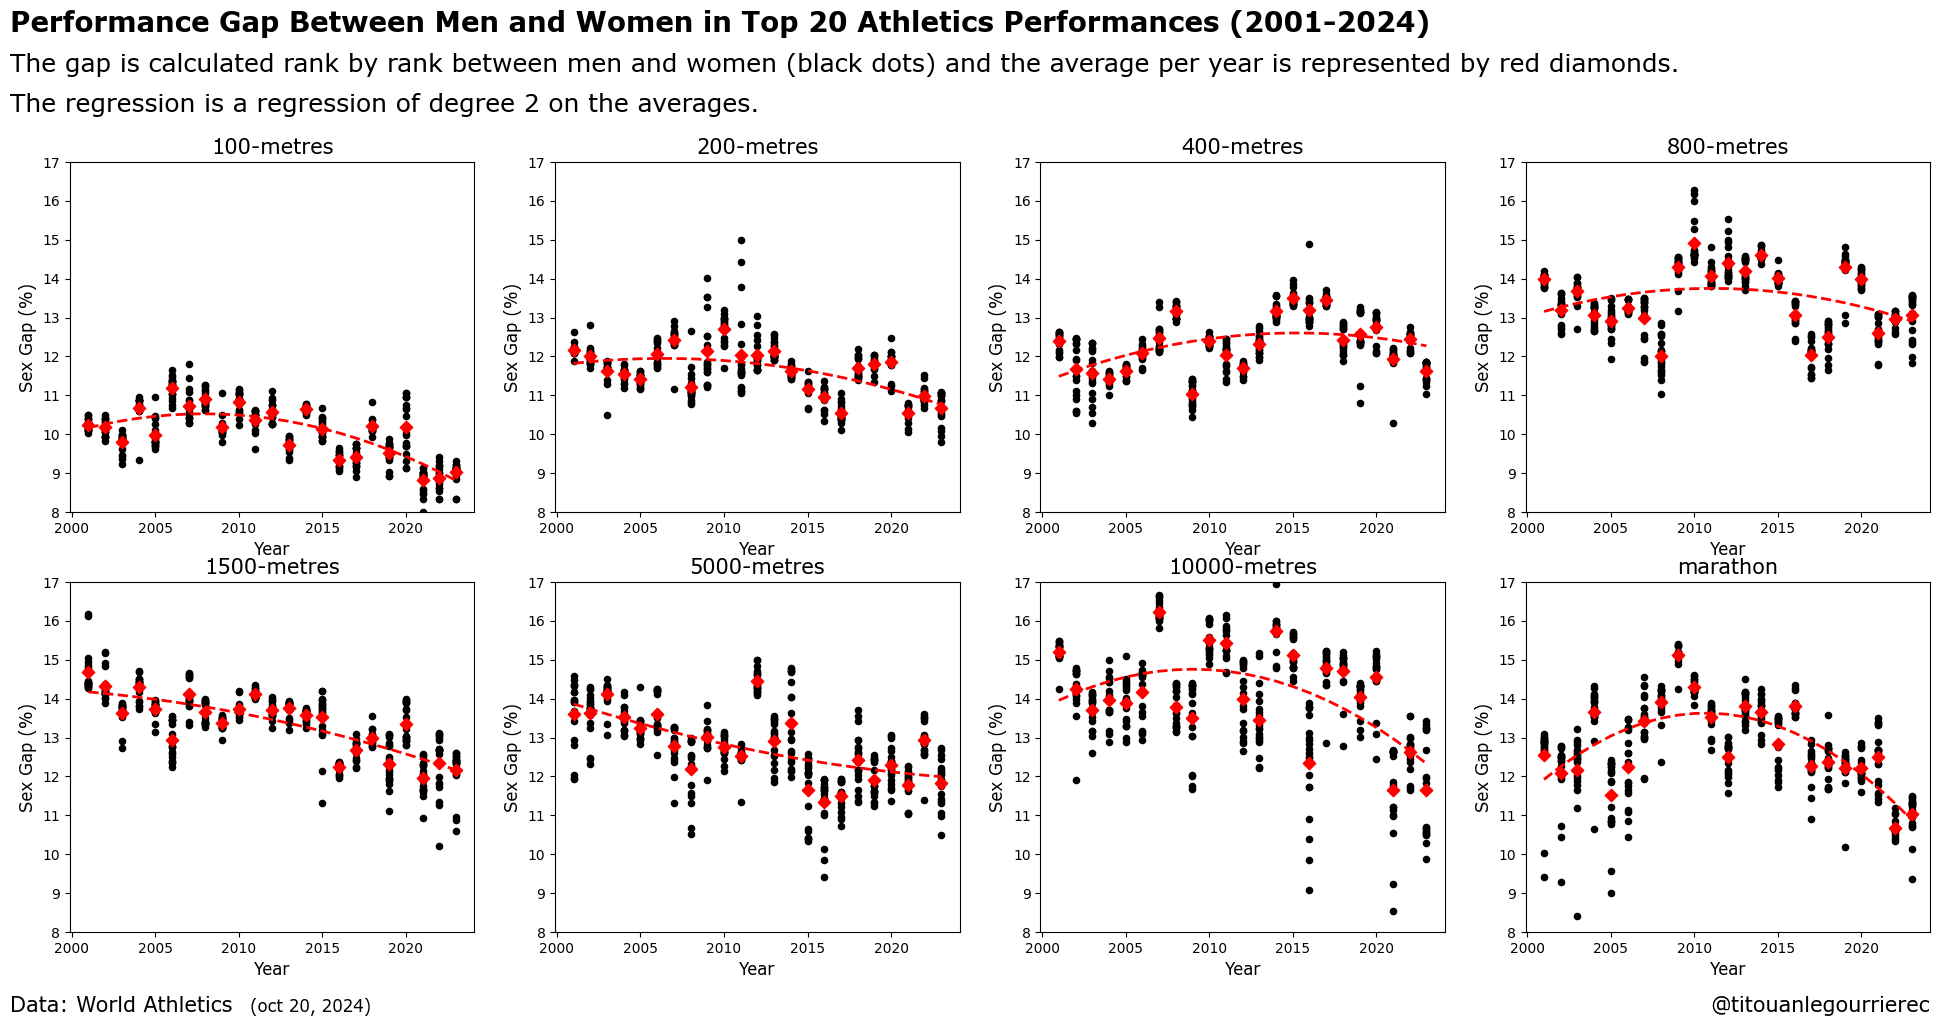

In [9]:
df = pd.read_csv("data/top100_all_2001_2024.csv")

years = range(2001, 2024)
disciplines = ["100-metres", "200-metres", "400-metres", "800-metres", "1500-metres", "5000-metres", "10000-metres", "marathon"]

fig, axes = plt.subplots(2, 4, figsize=(24, 10))
axes = axes.flatten()

for ax, discipline in zip(axes, disciplines):
    gap = []
    for year in years:
        try:
            _, sex_gap_list = topsexgap(df, discipline=discipline, year=year, top_n=20)
            gap.append(sex_gap_list)
        except IndexError:
            print(f"Not enough data for {discipline} in {year}")
            continue

    # Calculate the average for each year
    average_values = [np.mean(valeurs) for valeurs in gap]

    # Plot individual values
    for (annee, valeurs) in zip(years, gap):
        for valeur in valeurs:
            ax.scatter(annee, valeur, color='black', s=20)

    # Plot red diamonds for each average
    for annee, moyenne in zip(years, average_values):
        ax.scatter(annee, moyenne, color='red', marker='D', s=40)

    # Fit a polynomial regression model of degree 2
    X = np.array(years).reshape(-1, 1)
    y = np.array(average_values)
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(X)
    model = LinearRegression().fit(X_poly, y)
    trend = model.predict(X_poly)

    ax.plot(years, trend, color='red', linestyle='--', linewidth=2)

    ax.set_xlabel("Year", font='Verdana', fontsize=12)
    ax.set_ylabel("Sex Gap (%)", font='Verdana', fontsize=12)
    ax.set_title(discipline, font='Verdana', fontsize=15)

    ax.set_ylim(8, 17)

fig.text(0.1, 1.01, 'Performance Gap Between Men and Women in Top 20 Athletics Performances (2001-2024)', font='Verdana', fontsize=20, fontweight='bold', ha='left', bbox=dict(facecolor='white', edgecolor='none'))
fig.text(0.1, 0.97, 'The gap is calculated rank by rank between men and women (black dots) and the average per year is represented by red diamonds.', font='Verdana', fontsize=18, ha='left')
fig.text(0.1, 0.93, 'The regression is a regression of degree 2 on the averages.', font='Verdana', fontsize=18, ha='left')

fig.text(0.1, 0.03, 'Data: World Athletics', font='Verdana', fontsize=15, ha='left', color='black', bbox=dict(facecolor='white', edgecolor='none'))
fig.text(0.2, 0.03, '(oct 20, 2024)', font='Verdana', fontsize=12, ha='left', color='black', bbox=dict(facecolor='white', edgecolor='none'))
fig.text(0.9, 0.03, '@titouanlegourrierec', font='Verdana', fontsize=15, ha='right', color='black', bbox=dict(facecolor='white', edgecolor='none'))

plt.show()